If you have access to multiple GPUs (T4 x2 in this case), you can further optimize the computation by leveraging both GPUs simultaneously. PyTorch makes it possible to distribute the workload across multiple GPUs, thereby significantly improving the speed of the embedding computation.

### Steps to Leverage Multiple GPUs

1. **Data Parallelism**: Use PyTorch’s `DataParallel` or `DistributedDataParallel` to distribute the model across multiple GPUs.
2. **Batch Processing with DataLoader**: Modify the DataLoader to work efficiently with multiple GPUs.
3. **Efficient Data and Model Distribution**: Ensure that data is moved to the appropriate GPU and that the model is replicated on each GPU.

Here’s how you can modify your code to leverage both GPUs:

### Multi-GPU Code Implementation

1. **Import Required Libraries**

Ensure you have the necessary PyTorch libraries for handling multiple GPUs.

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parallel import DataParallel
from transformers import AutoImageProcessor, Dinov2Model
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

2024-06-20 12:37:50.469591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 12:37:50.469702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 12:37:50.607516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2. **Set Up DataLoader for Batch Processing**

Prepare the dataset and DataLoader for efficient batching.

In [2]:
# Load data
train_path = '/kaggle/input/digit-recognizer/train.csv'
train_data = pd.read_csv(train_path)

X_train = train_data.drop(columns=['label']).values
y_train = train_data['label'].values
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0

# Convert images to RGB
X_train_rgb_tensor = torch.tensor(np.repeat(X_train, 3, axis=-1), dtype=torch.float32)

In [3]:
# Create a DataLoader
batch_size = 512
dataset = TensorDataset(X_train_rgb_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

3. **Initialize DINO Model and Image Processor**

Make sure to initialize the model and image processor.

In [4]:
# Initialize DINO v2 model and image processor
model_name = "facebook/dinov2-small"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = Dinov2Model.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

4. **Move Model to GPU and Parallelize**

Use `DataParallel` to run the model on multiple GPUs.

In [5]:
# Use all available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = DataParallel(model)

model.to(device)
model.eval()

DataParallel(
  (module): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
         

5. **Compute Embeddings with Multi-GPU**

Process the embeddings using both GPUs.

In [6]:
%%time
# Compute embeddings
embeddings = []
with torch.no_grad():
    for batch in dataloader:
        batch_images = batch[0].to(device)
        inputs = image_processor(images=batch_images, return_tensors="pt", do_resize=False, do_rescale=False, do_normalize=False)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        output = model(**inputs).last_hidden_state[:, 0, :]
        embeddings.append(output.cpu())

embeddings = torch.cat(embeddings, dim=0)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: torch.Size([42000, 384])
CPU times: user 2min 11s, sys: 25.8 s, total: 2min 37s
Wall time: 2min 24s


### Key Points to Note

- **Batch Size**: You may need to experiment with the batch size based on your GPU memory. Larger batch sizes will typically lead to better utilization of the GPUs, but they also require more memory.
- **Multi-GPU Support**: Ensure that your environment is set up to support multi-GPU computations. This may involve configuring your PyTorch environment and CUDA drivers.
- **Efficient Data Movement**: Ensure that data is moved efficiently between CPU and GPUs to minimize bottlenecks.
- **Model Evaluation Mode**: Setting the model to evaluation mode (`model.eval()`) disables dropout and other non-deterministic layers, ensuring consistent performance and memory usage.

6. **Rest of the Workflow**

Continue with the dimensionality reduction, clustering, and visualization as previously detailed.

In [7]:
# PCA and clustering
embeddings_np = embeddings.numpy()
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

In [8]:
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embeddings_2d)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
# Compute centroids
centroids = []
for cluster in np.unique(clusters):
    cluster_points = embeddings_2d[clusters == cluster]
    centroid = cluster_points.mean(axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)


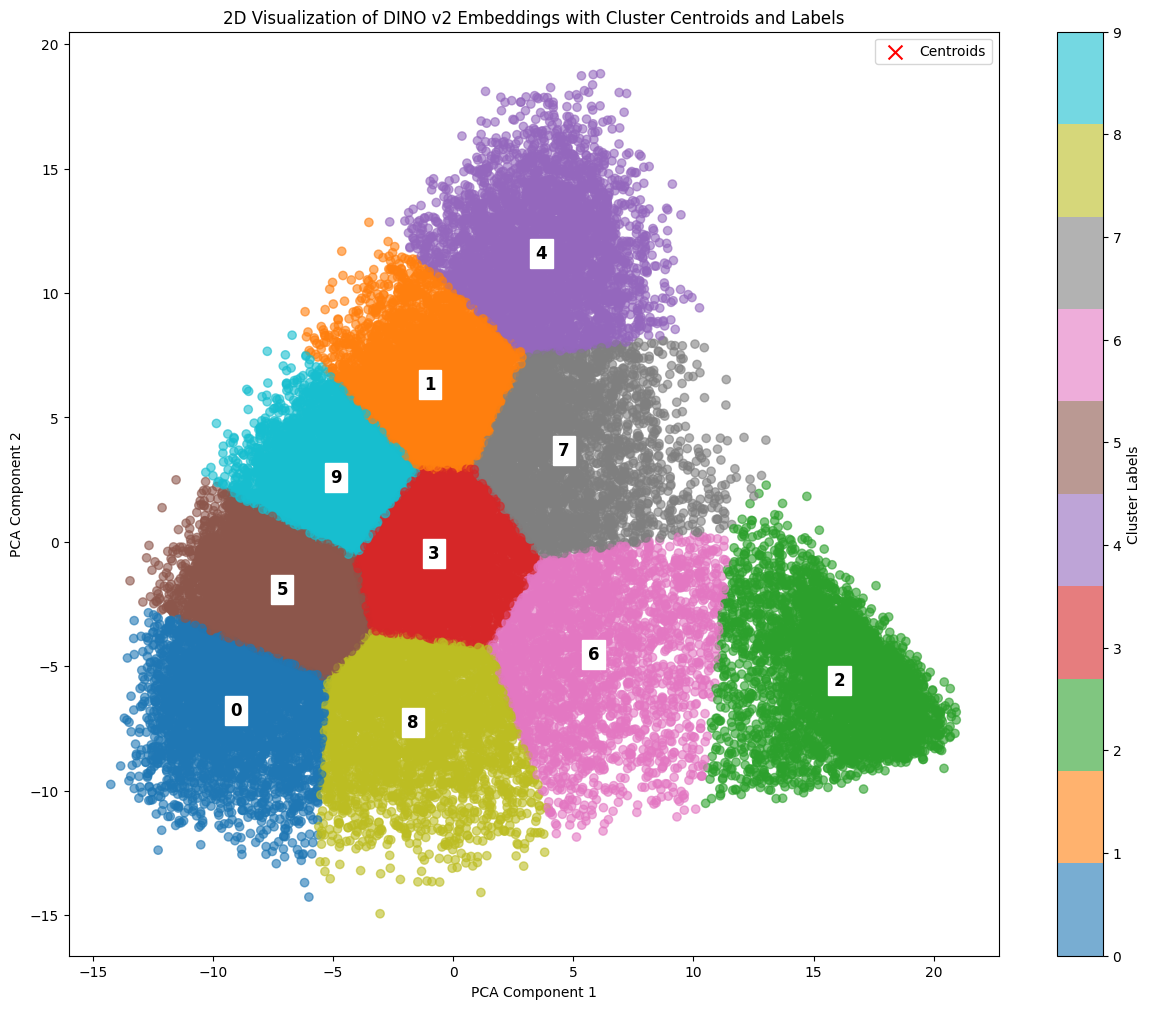

In [10]:
plt.figure(figsize=(15, 12))

# Scatter plot of the data points
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10), label='Cluster Labels')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x', label='Centroids')

# Annotate centroids with cluster numbers
for i, centroid in enumerate(centroids):
    plt.text(centroid[0], centroid[1], str(i), fontsize=12, fontweight='bold', ha='center', va='center', color='black', backgroundcolor='white')

# Add titles and labels
plt.title('2D Visualization of DINO v2 Embeddings with Cluster Centroids and Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.show()


In [12]:
import random

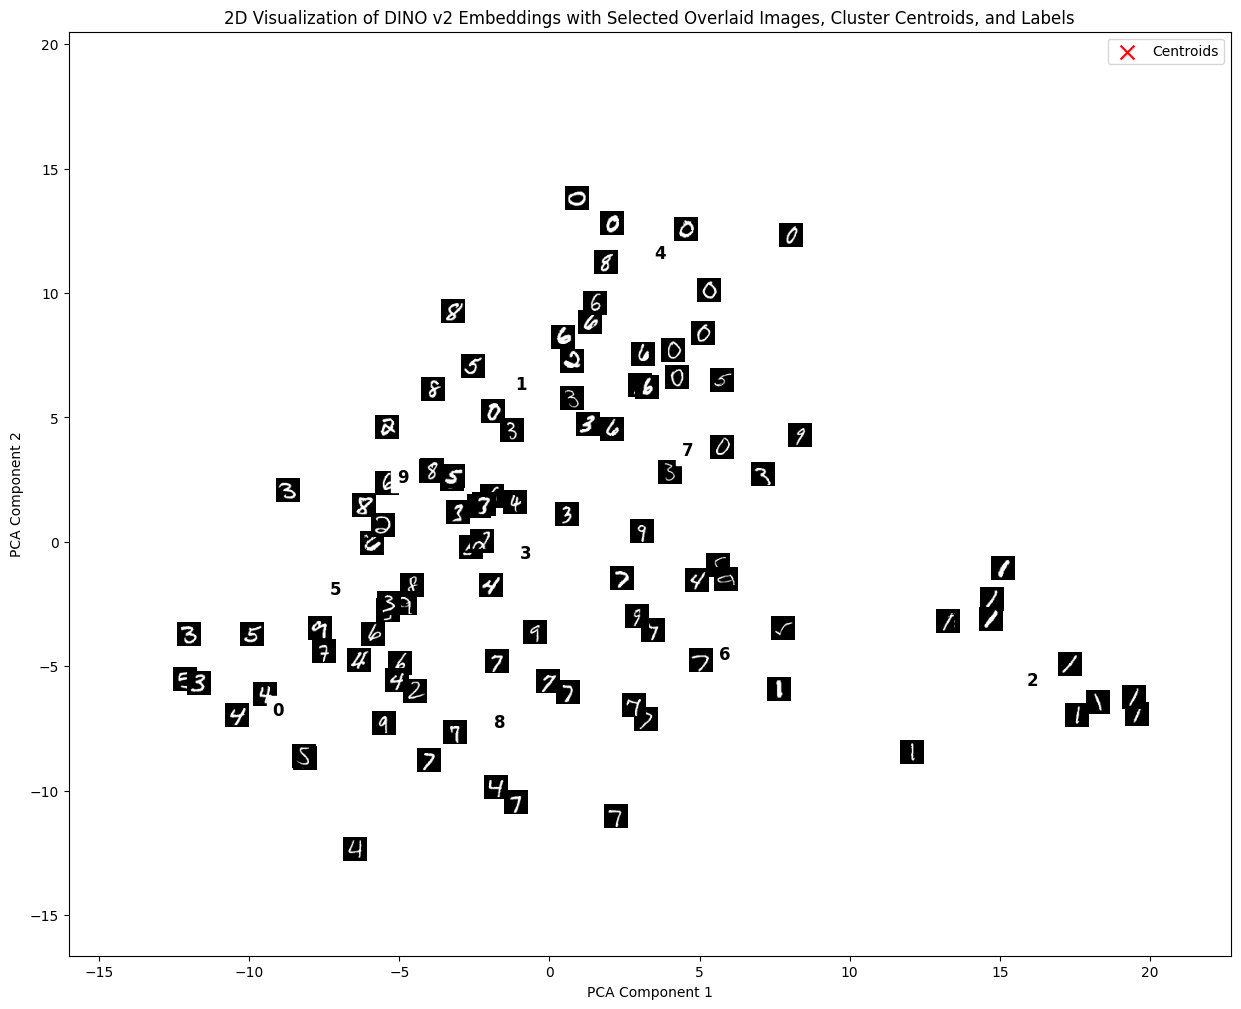

In [13]:
def imscatter_representative_with_centroids_labels(x, y, images, clusters, centroids, num_images=10, ax=None, zoom=0.1):
    if ax is None:
        ax = plt.gca()

    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        selected_indices = random.sample(list(cluster_indices), min(num_images, len(cluster_indices)))
        
        for idx in selected_indices:
            image = images[idx].reshape(28, 28)
            im = OffsetImage(image, zoom=zoom, cmap='gray')
            ab = AnnotationBbox(im, (x[idx], y[idx]), frameon=False)
            ax.add_artist(ab)
    
    # Plot centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x', label='Centroids')
    
    # Annotate centroids with cluster numbers
    for i, centroid in enumerate(centroids):
        ax.text(centroid[0], centroid[1], str(i), fontsize=12, fontweight='bold', ha='center', va='center', color='black', backgroundcolor='white')
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    ax.legend()

plt.figure(figsize=(15, 12))
imscatter_representative_with_centroids_labels(embeddings_2d[:, 0], embeddings_2d[:, 1], X_train.squeeze(), clusters, centroids, num_images=10, zoom=0.6)
plt.colorbar(scatter, ticks=range(10), label='Cluster Labels')
plt.title('2D Visualization of DINO v2 Embeddings with Selected Overlaid Images, Cluster Centroids, and Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


To display a grid of representative images for each cluster, we can create a subplot grid where each row corresponds to a cluster, and each column shows an image from that cluster. This approach provides a visual summary of the characteristics of each cluster.

### Steps to Create a Grid of Images for Each Cluster

1. **Group Images by Cluster**: Organize images according to their cluster labels.
2. **Select Representative Images**: Choose a specified number of images from each cluster.
3. **Create Subplots**: Use subplots to arrange the images in a grid format.

**Group Images by Cluster and Select Representative Images**

Group images by their clusters and select a sample of images from each cluster.

In [14]:
def select_representative_images(images, clusters, num_images_per_cluster=10):
    cluster_images = {}
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        selected_indices = random.sample(list(cluster_indices), min(num_images_per_cluster, len(cluster_indices)))
        cluster_images[cluster] = images[selected_indices]
    return cluster_images


**Create the Grid of Images for Each Cluster**

Create a function to plot the grid of images.

In [15]:
def plot_cluster_images_grid(cluster_images, num_images_per_cluster=10):
    num_clusters = len(cluster_images)
    fig, axes = plt.subplots(num_clusters, num_images_per_cluster, figsize=(num_images_per_cluster * 2, num_clusters * 2))
    for i, (cluster, images) in enumerate(cluster_images.items()):
        for j in range(num_images_per_cluster):
            ax = axes[i, j] if num_clusters > 1 else axes[j]
            if j < len(images):
                ax.imshow(images[j].reshape(28, 28), cmap='gray')
                ax.axis('off')
            else:
                ax.axis('off')
        ax.set_title(f'Cluster {cluster}', fontsize=14)
    
    plt.tight_layout()
    plt.show()


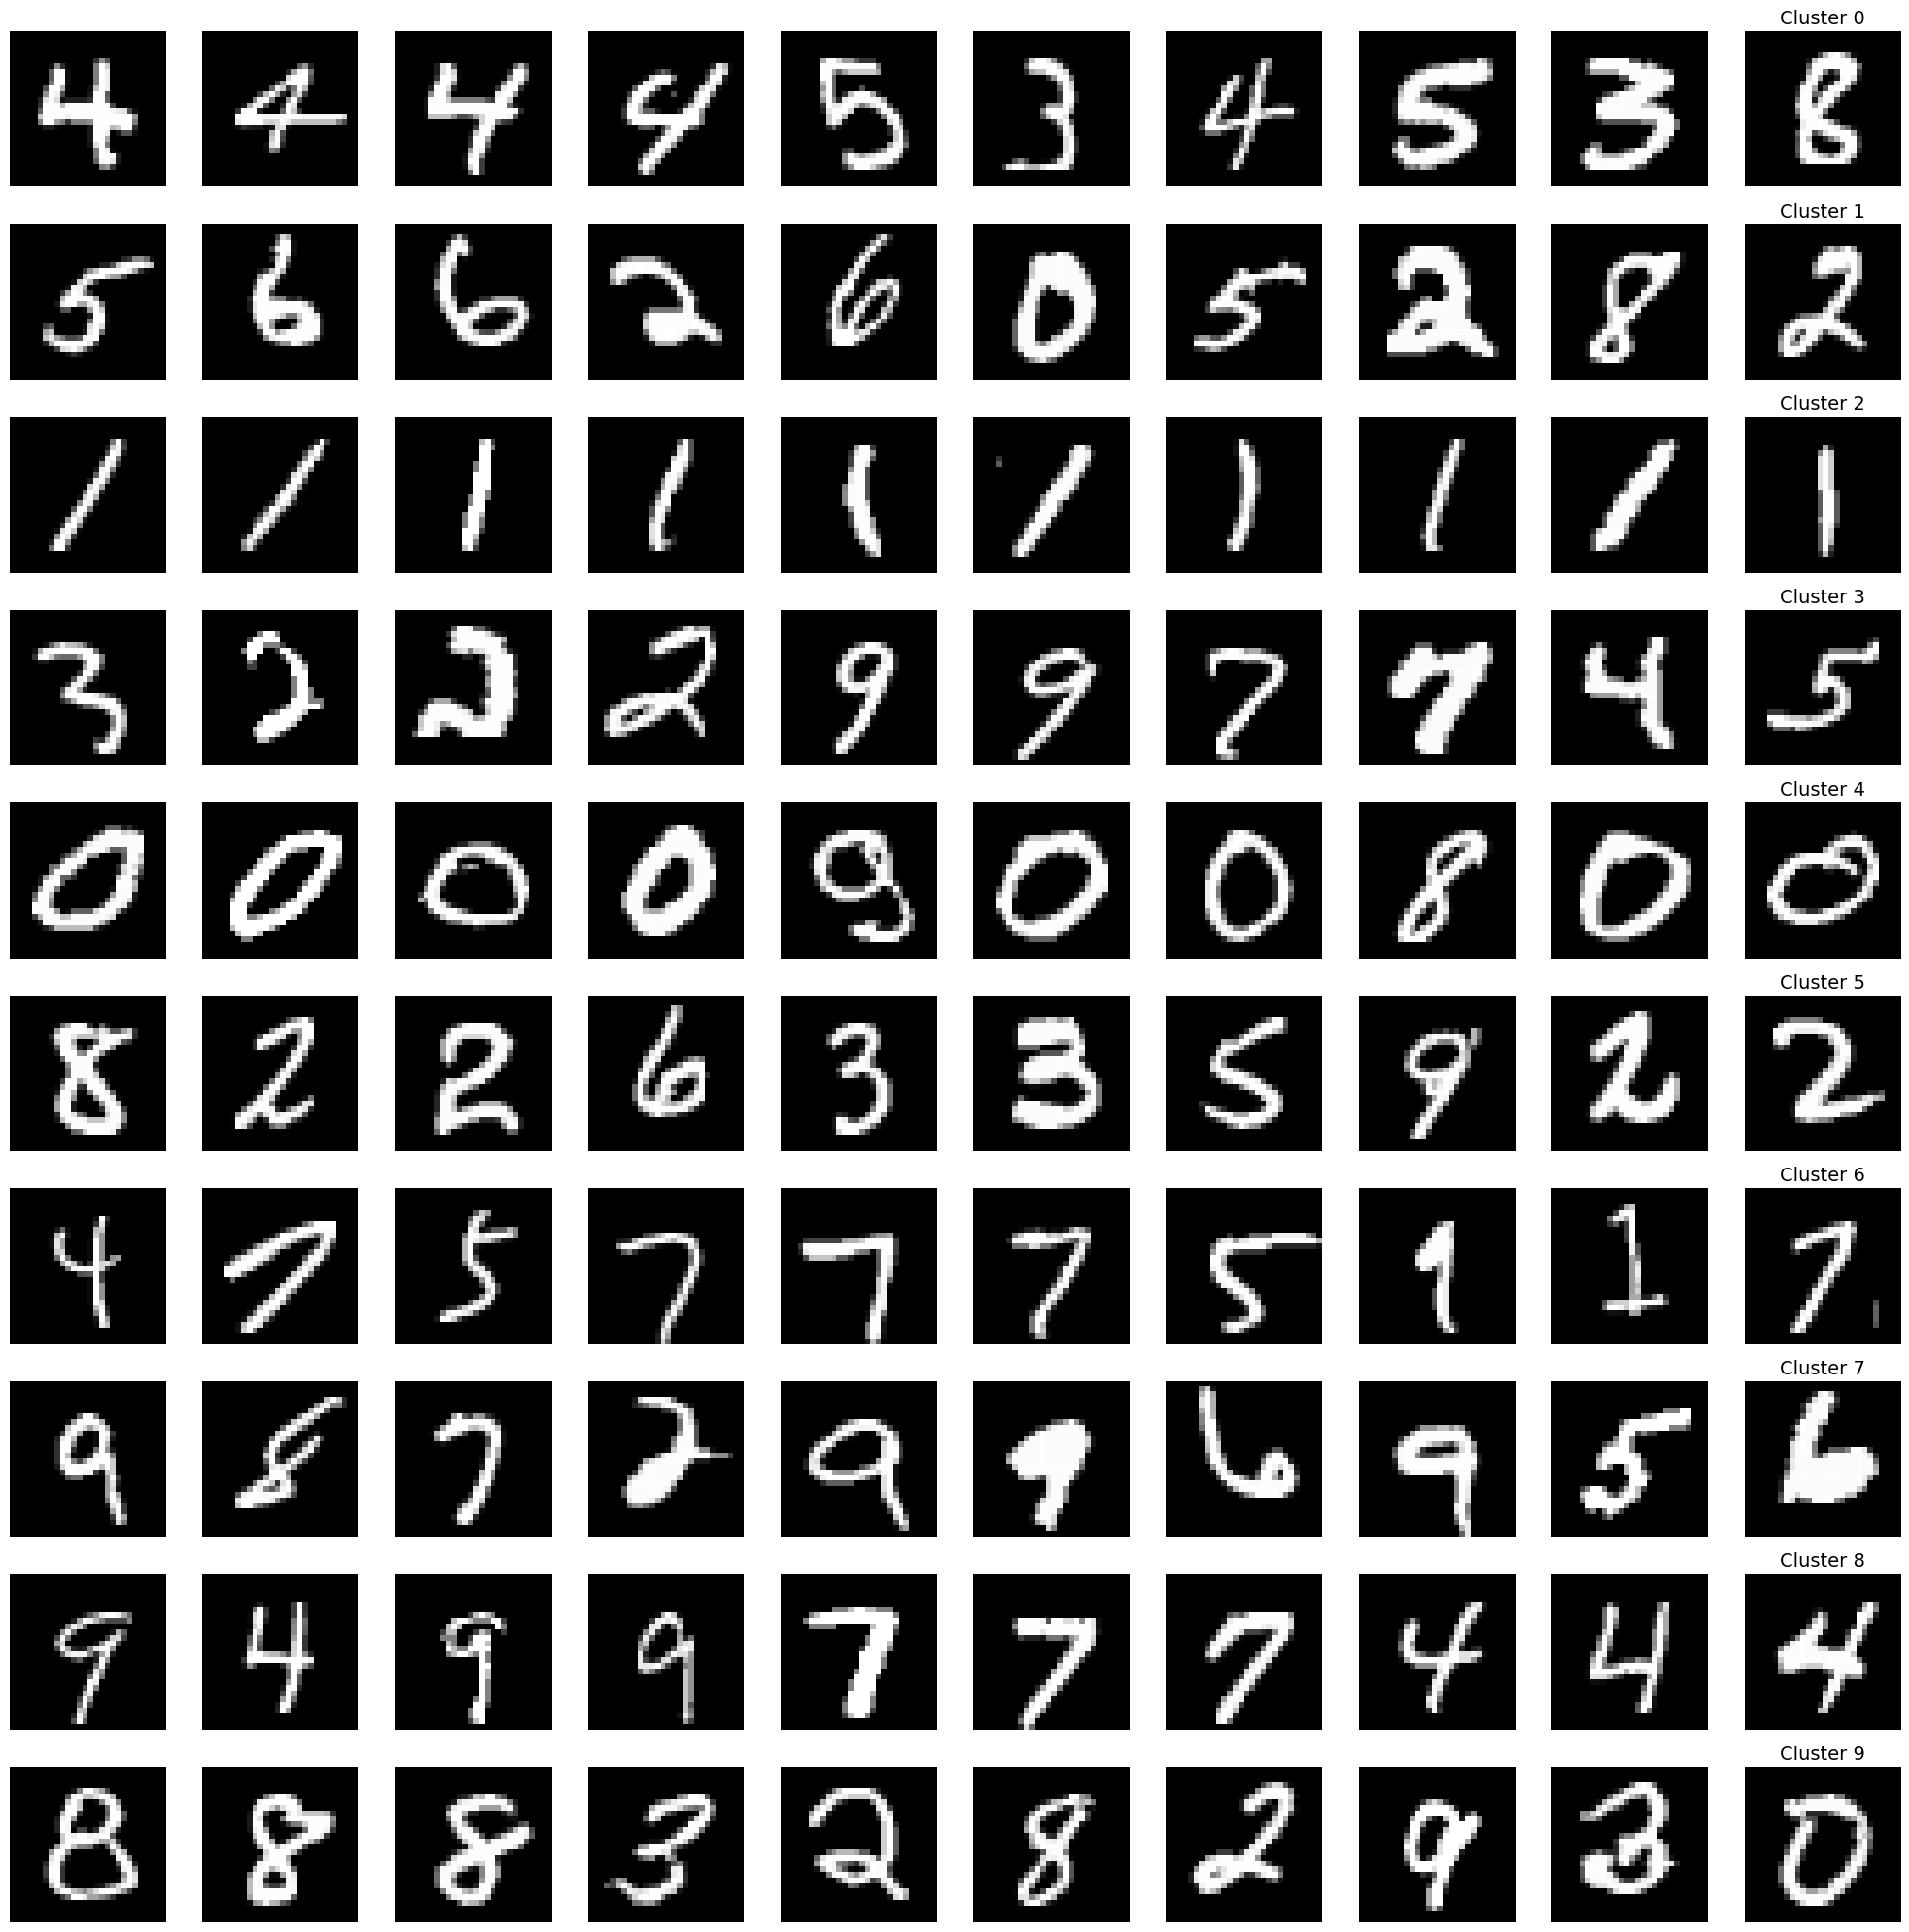

In [16]:
# Select representative images
cluster_images = select_representative_images(X_train, clusters, num_images_per_cluster=10)

# Plot the grid
plot_cluster_images_grid(cluster_images, num_images_per_cluster=10)


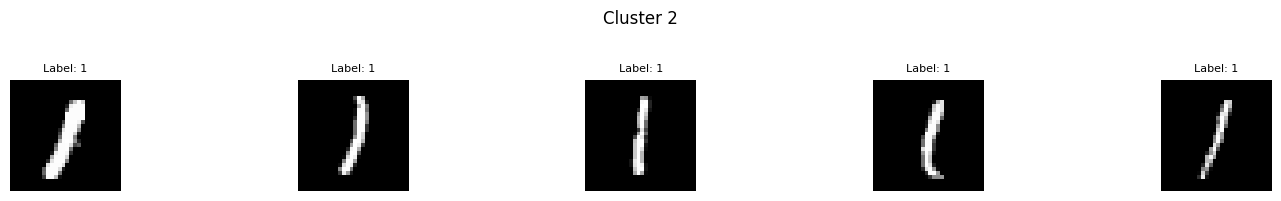

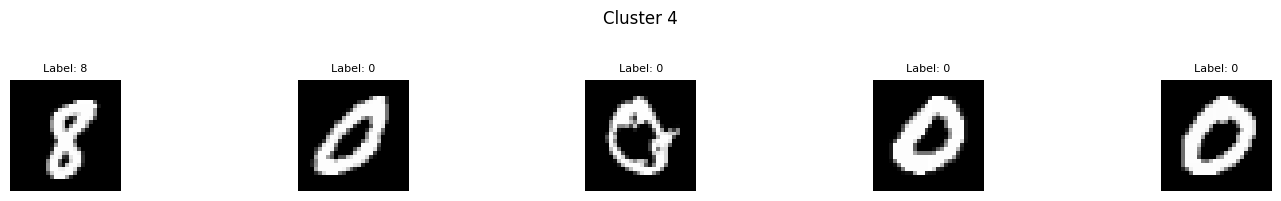

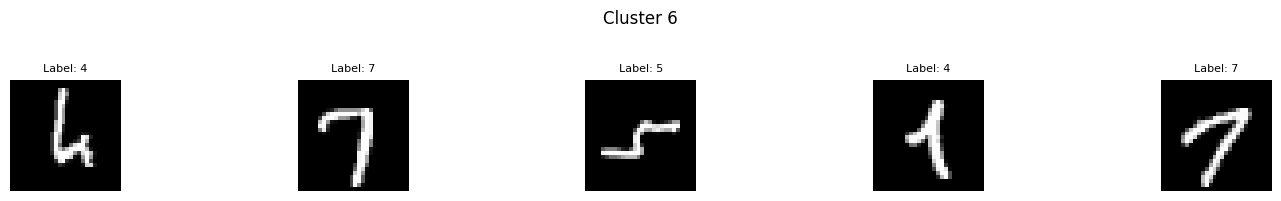

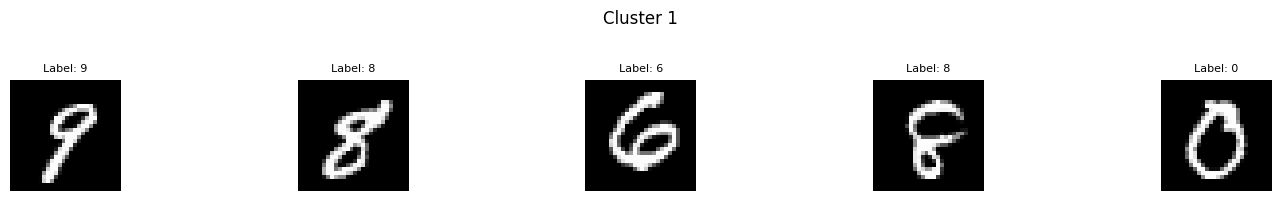

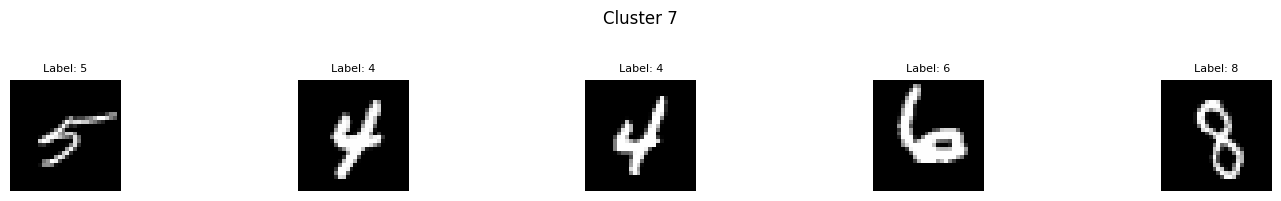

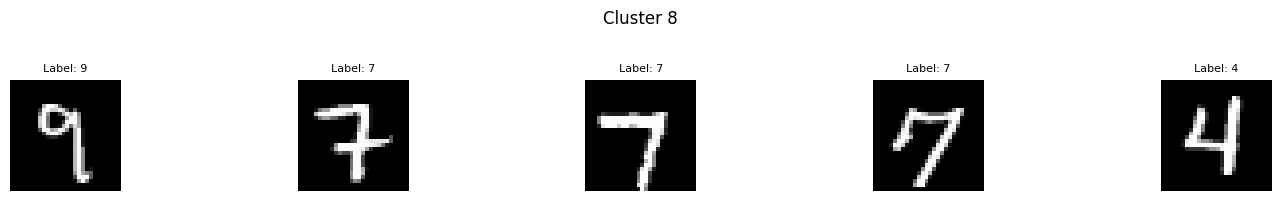

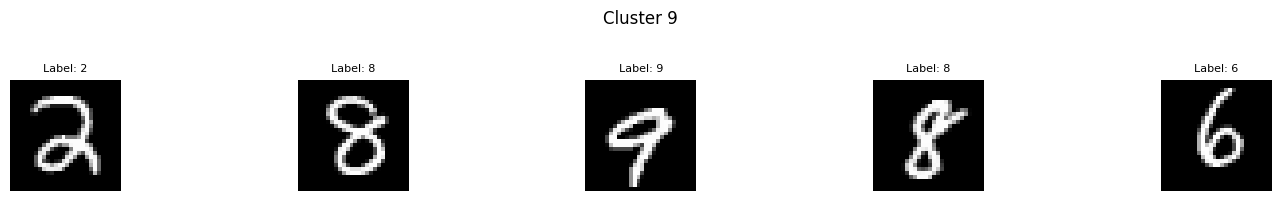

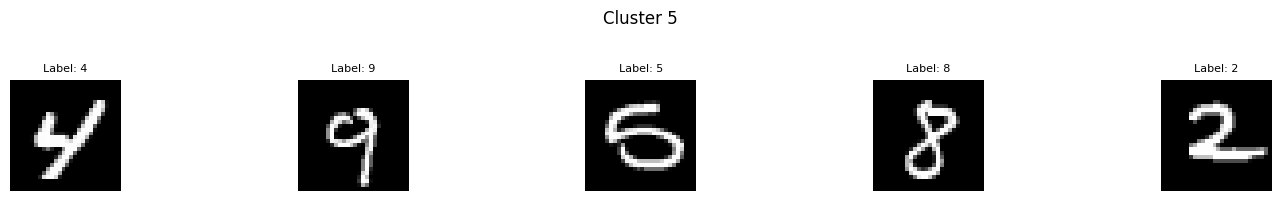

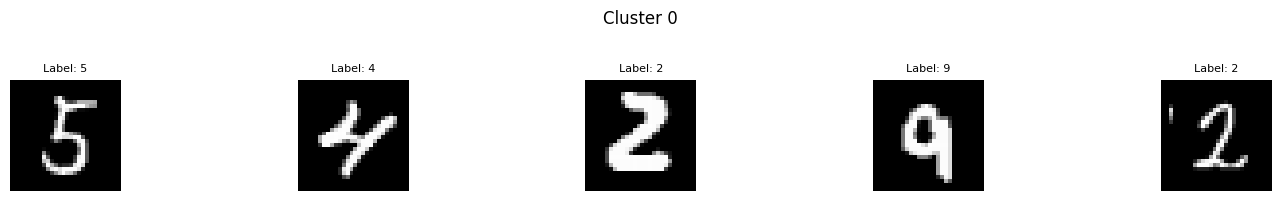

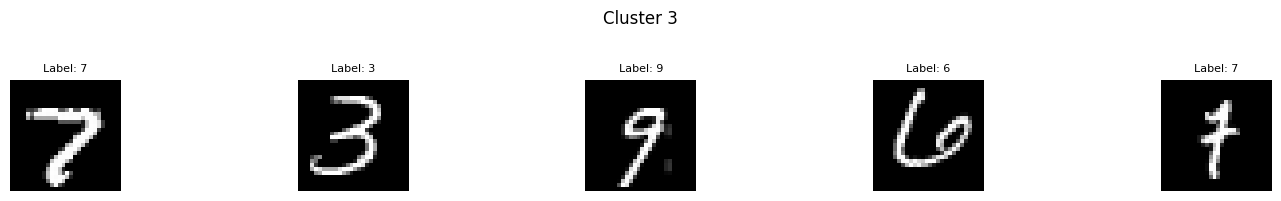

In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import random


data = {
    'y': y_train,
    'cluster': clusters
}
df = pd.DataFrame(data)

# Define the number of images to display from each cluster
num_images_per_cluster = 5

# Get the unique cluster labels
n_clusters = df['cluster'].unique()

# Create a figure for each cluster
for cluster in n_clusters:
    # Get all images in the current cluster
    cluster_df = df[df['cluster'] == cluster]
    
    # Randomly select and display images from the cluster
    selected_indices = cluster_df.sample(min(num_images_per_cluster, len(cluster_df))).index
    
    # Load and resize the images
    resized_images = []
    for idx in selected_indices:
        image = X_train[idx].squeeze()  # Assuming images are already in correct format
        image = Image.fromarray((image * 255).astype('uint8'))  # Convert numpy array to PIL Image
        # Uncomment and adjust if resizing is necessary
        # image = image.resize((50, 50))
        resized_images.append(image)
    
    # Create a figure and axis for the cluster
    fig, axs = plt.subplots(1, num_images_per_cluster, figsize=(15, 2))
    
    # Plot each image and write the label
    for i, (image, idx) in enumerate(zip(resized_images, selected_indices)):
        ax = axs[i]
        ax.imshow(image, cmap='gray')  # Ensure grayscale colormap for grayscale images
        ax.set_title(f'Label: {y_train[idx]}', fontsize=8)  # Show true label as title
        ax.axis('off')
    
    # Add a title for the cluster
    fig.suptitle(f'Cluster {cluster}', fontsize=12)
    
    # Adjust spacing and display the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [19]:
# Group by true labels 'y' and calculate average predicted cluster 'cluster'
avg_predicted_per_true = df.groupby('y')['cluster'].mean()

# Display the result
print(avg_predicted_per_true)

y
0    4.049855
1    2.328352
2    4.421355
3    4.670191
4    4.917240
5    3.895916
6    5.005076
7    5.906839
8    4.790795
9    4.529131
Name: cluster, dtype: float64


This approach gives you a quantitative measure of how predicted clusters align on average with each true label, providing insight into the clustering model's performance relative to the true labels in your dataset. 

In [20]:
# Compute mode of y (true labels) per cluster
mode_y_per_cluster = df.groupby('cluster')['y'].agg(lambda x: x.mode().iloc[0])

# Display the result
print(mode_y_per_cluster)

cluster
0    5
1    6
2    1
3    9
4    0
5    2
6    7
7    6
8    7
9    3
Name: y, dtype: int64


This approach gives you a direct insight into which true label (y) is most frequently associated with each predicted cluster, which can be useful for evaluating the clustering results and understanding how well clusters correspond to the true categories in your dataset.